In [12]:
# Setup and Configuration
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Configuration ---
DB_PATH = '../../../dataset/supervised_dataset.duckdb'
LABELED_TABLE = 'labeled_training_data_new_approach' 

sns.set_theme(style="whitegrid")

warnings.filterwarnings('ignore') 

In [2]:
# Load Labeled Data
print("\nLoading labeled feature data...")
try:
    con = duckdb.connect(database=DB_PATH, read_only=True)
    
    # Check if our labeled table exists
    tables = con.execute("SHOW TABLES").fetchdf()['name'].tolist()
    if LABELED_TABLE not in tables:
        raise ValueError(f"Missing labeled table: '{LABELED_TABLE}'. Did script 04 run?")
    
    # Load the data
    df_labeled = con.query(f"SELECT * FROM {LABELED_TABLE}").to_df()
    con.close()
    
    print("Labeled data loaded successfully.")
    print(f"Dataset shape: {df_labeled.shape}")
    
    # Final check on class distribution
    print("\nClass Distribution:")
    print(df_labeled['is_insider'].value_counts())
    
    if 1 not in df_labeled['is_insider'].value_counts():
        print("\nWARNING: No insiders (label '1') found in the data!")

except Exception as e:
    print(f"--- CRITICAL ERROR: Could not load data ---")
    print(f"Error: {e}")
    raise



Loading labeled feature data...
Labeled data loaded successfully.
Dataset shape: (1000, 38)

Class Distribution:
is_insider
0    930
1     70
Name: count, dtype: int64



Generating Plot 1: Anomaly Score vs. Insider Label


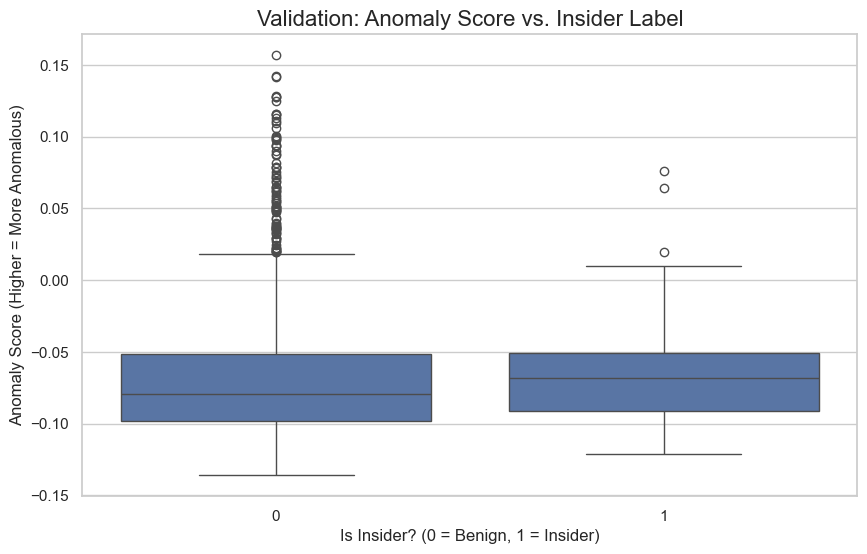

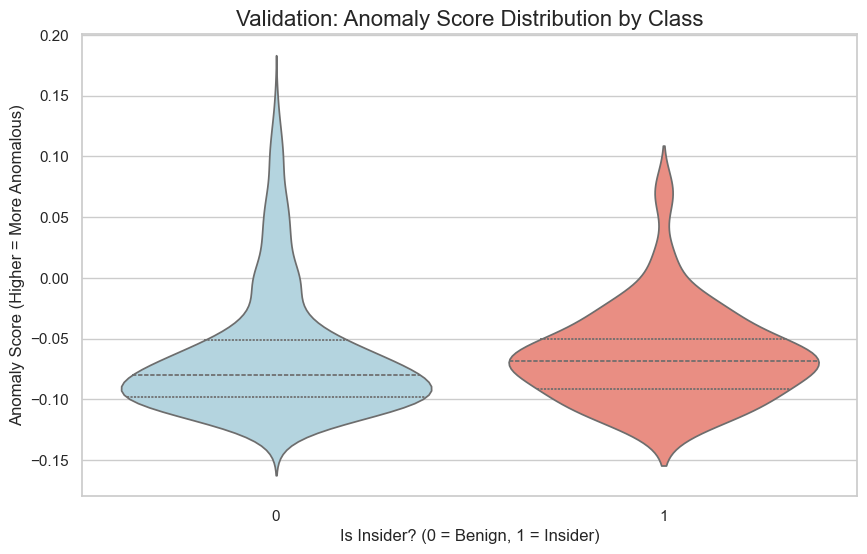

In [4]:
# VALIDATION 1: Anomaly Score vs. Insider Label
print("\nGenerating Plot 1: Anomaly Score vs. Insider Label")
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_labeled,
    x='is_insider',
    y='anomaly_score'
)
plt.title('Validation: Anomaly Score vs. Insider Label', fontsize=16)
plt.xlabel('Is Insider? (0 = Benign, 1 = Insider)')
plt.ylabel('Anomaly Score (Higher = More Anomalous)')
plt.show()

# Also show this as a violin plot for more detail on distribution
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_labeled,
    x='is_insider',
    y='anomaly_score',
    hue='is_insider',
    inner='quartile',
    palette={0: "lightblue", 1: "salmon"},
    legend=False
)
plt.title('Validation: Anomaly Score Distribution by Class', fontsize=16)
plt.xlabel('Is Insider? (0 = Benign, 1 = Insider)')
plt.ylabel('Anomaly Score (Higher = More Anomalous)')
plt.show()

In [6]:
# VALIDATION 2: The "Benign Outlier" Check
print("\nChecking on 'Benign Outlier' user 'ATE0869'...")
benign_outlier_user = 'ATE0869'

if benign_outlier_user in df_labeled['user_id'].values:
    user_record = df_labeled[df_labeled['user_id'] == benign_outlier_user].iloc[0]
    
    print(f"--- Benign Outlier Analysis: {benign_outlier_user} ---")
    print(f"  User ID:       {user_record['user_id']}")
    print(f"  Anomaly Score: {user_record['anomaly_score']:.4f} (This was the #1 highest)")
    print(f"  Actual Label:  {user_record['is_insider']} (We expect 0)")
    
    if user_record['is_insider'] == 0:
        print("\nThis confirms our hypothesis: 'Anomalous' (high score) does NOT equal 'Malicious' (label 1).")
    else:
        print("\nINTERESTING: This user *is* in your label set. This is a perfect example of a 'Malicious Anomaly'.")
else:
    print(f"User '{benign_outlier_user}' not found in the labeled dataset.")


Checking on 'Benign Outlier' user 'ATE0869'...
--- Benign Outlier Analysis: ATE0869 ---
  User ID:       ATE0869
  Anomaly Score: 0.1568 (This was the #1 highest)
  Actual Label:  0 (We expect 0)

This confirms our hypothesis: 'Anomalous' (high score) does NOT equal 'Malicious' (label 1).



Calculating feature correlation with 'is_insider' label...

--- Top 10 Most Correlated Features (Absolute) ---
| Feature                 |   Abs. Correlation |
|:------------------------|-------------------:|
| unique_cc               |          0.141379  |
| total_emails            |          0.137684  |
| total_email_size        |          0.137517  |
| total_http_events       |          0.132719  |
| unique_recipients       |          0.130814  |
| logon_unique_pcs        |          0.129576  |
| total_attachments       |          0.114616  |
| total_logon_events      |          0.0948705 |
| logon_ratio             |          0.0664146 |
| logon_after_hours_ratio |          0.0635779 |


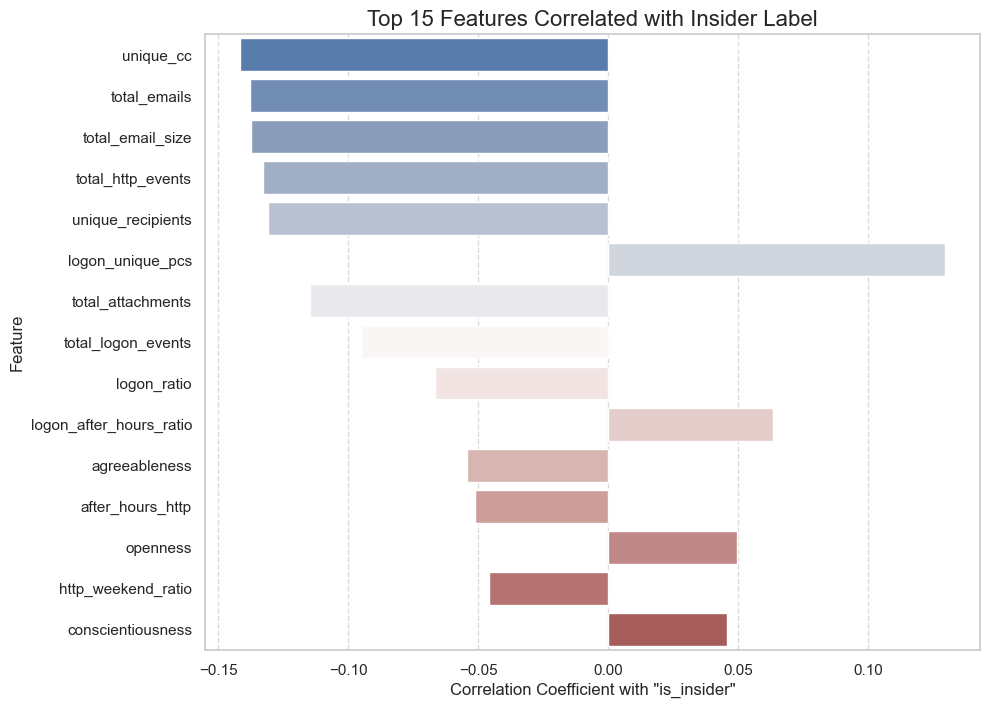

In [13]:
# VALIDATION 3: Feature Correlation with Target

print("\nCalculating feature correlation with 'is_insider' label...")

# Drop user_id for correlation calculation
features_for_corr = df_labeled.drop(columns=['user_id'])

# Calculate correlations
correlations = features_for_corr.corrwith(features_for_corr['is_insider']).sort_values(ascending=False)
correlations_abs = correlations.abs().sort_values(ascending=False)

print("\n--- Top 10 Most Correlated Features (Absolute) ---")
# [1:] to skip 'is_insider' itself (which has a 1.0 correlation)
print(correlations_abs[1:11].to_markdown(headers=["Feature", "Abs. Correlation"]))

# Plot the top 15
plt.figure(figsize=(10, 8))
# Use the non-absolute series to see direction (positive/negative)
top_features = correlations_abs[1:16].index
sns.barplot(
    x=correlations[top_features].values,
    y=top_features,
    hue=top_features,    
    palette="vlag",      # Red for positive, Blue for negative
    legend=False         
)
plt.title('Top 15 Features Correlated with Insider Label', fontsize=16)
plt.xlabel('Correlation Coefficient with "is_insider"')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Generating Distribution Plots for Top 5 Features...
Plotting distributions for: ['unique_cc', 'total_emails', 'total_email_size', 'total_http_events', 'unique_recipients', 'anomaly_score']


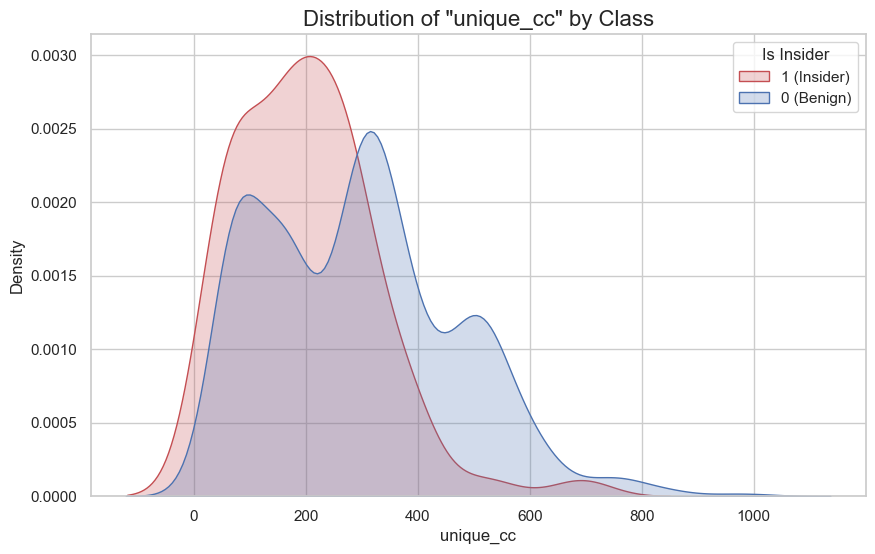

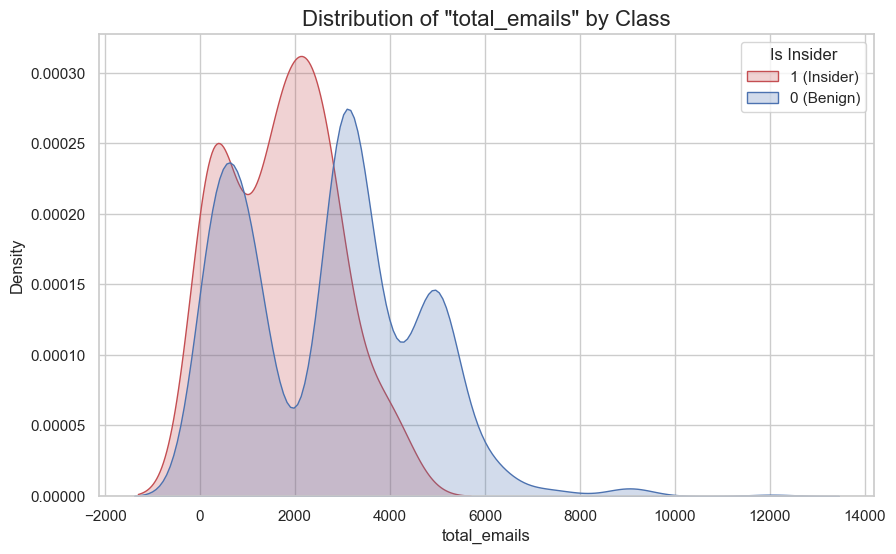

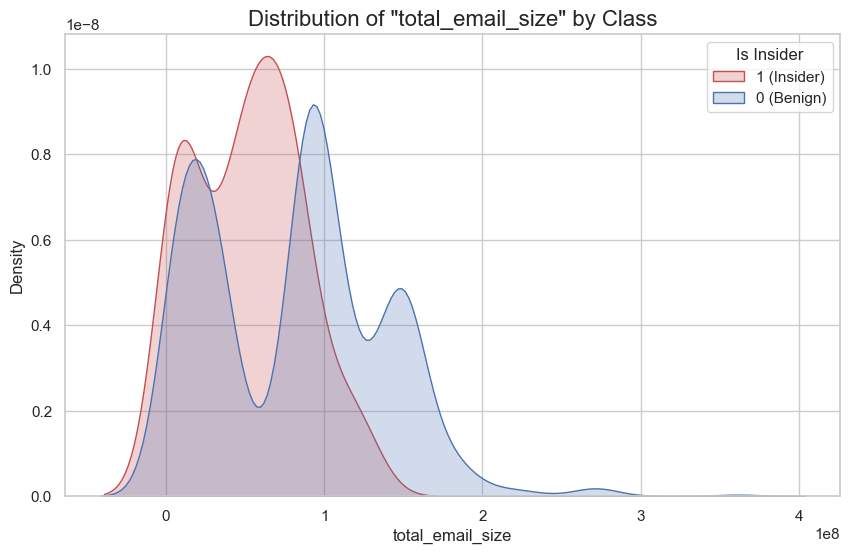

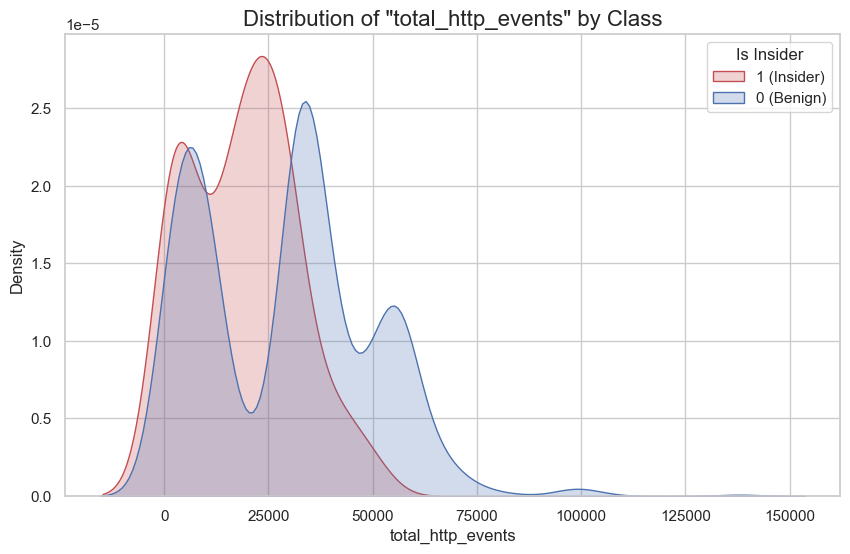

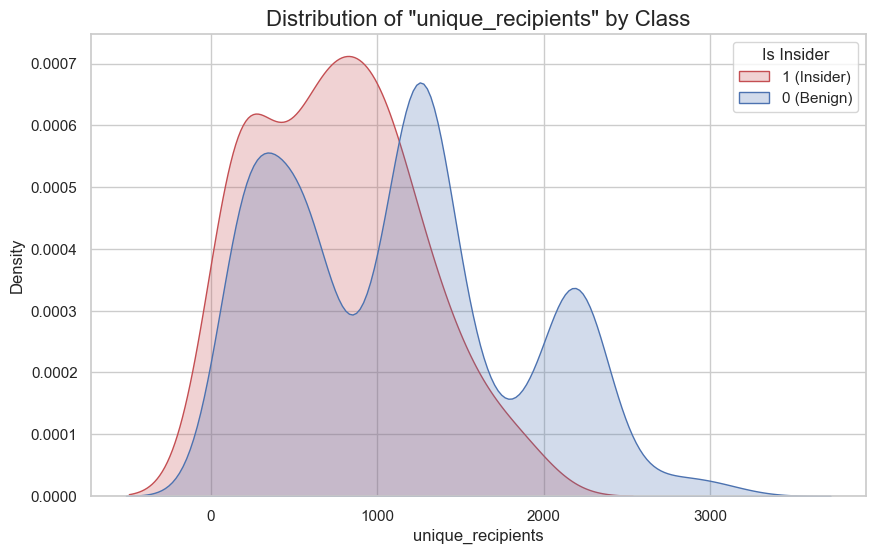

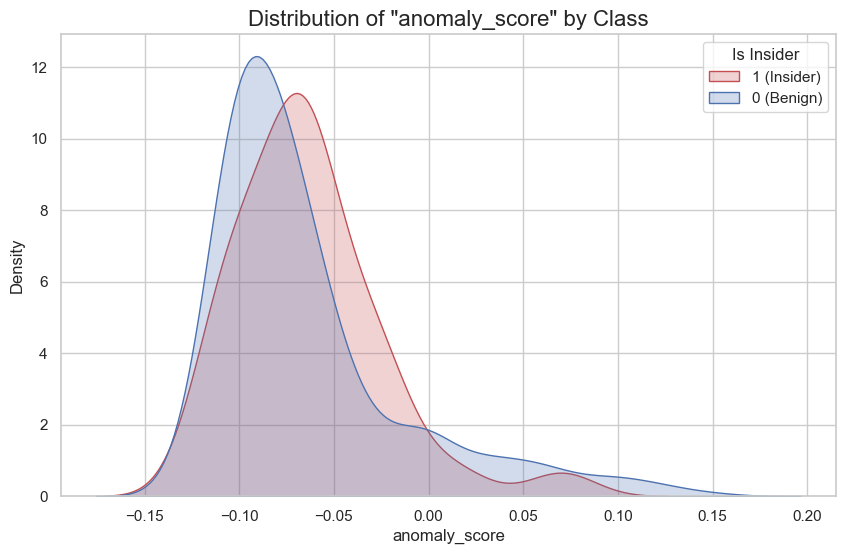

In [14]:
# VALIDATION 4: Distribution Plots for Top Features
print("\nGenerating Distribution Plots for Top 5 Features...")
top_5_features = correlations_abs.index[1:6].tolist()

# Just in case anomaly_score isn't in the top 5, let's check it anyway
if 'anomaly_score' not in top_5_features and 'anomaly_score' in df_labeled.columns:
    top_5_features.append('anomaly_score')

print(f"Plotting distributions for: {top_5_features}")

for feature in top_5_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(
        data=df_labeled,
        x=feature,
        hue='is_insider',
        fill=True,
        common_norm=False, # Show relative density for each class
        palette={0: 'b', 1: 'r'}
    )
    plt.title(f'Distribution of "{feature}" by Class', fontsize=16)
    plt.legend(title='Is Insider', labels=['1 (Insider)', '0 (Benign)'])
    plt.show()